# Aplicacion de limpieza y depuracion de imagenes para el conteo de Tornillos #

##### Preprocesamiento Inicial y Conversión #####

# Introducción al Conteo de Tornillos en Imágenes

Este notebook tiene como objetivo principal realizar el conteo de tornillos presentes en una imagen utilizando técnicas de procesamiento de imágenes y visión artificial. A través de este proceso, se aplican conceptos matemáticos y teóricos fundamentales para la manipulación, análisis y segmentación de imágenes. Cada paso del código está diseñado para garantizar la precisión en la detección y conteo de los objetos, teniendo en cuenta las características específicas de los tornillos y las condiciones de la imagen.

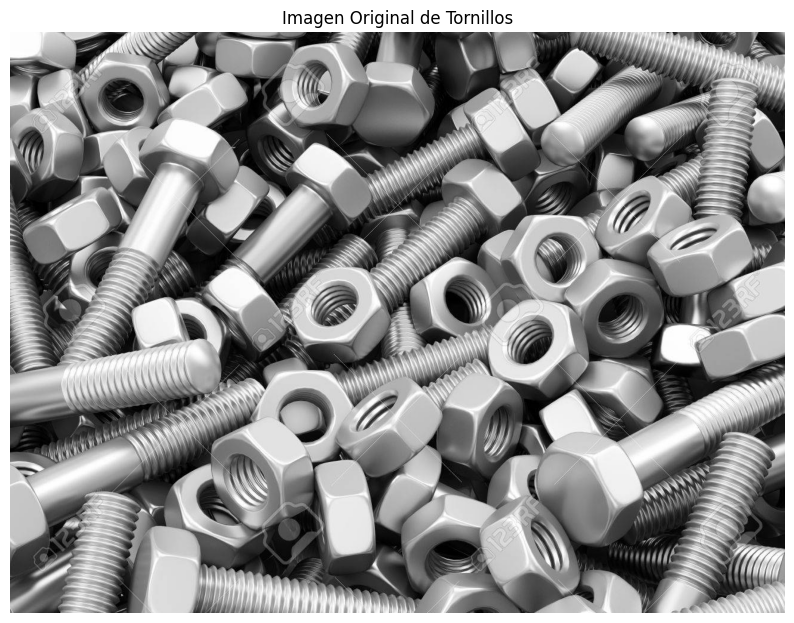

Tamaño de la imagen: 1300x975 píxeles
Canales: 3 (RGB)
Tipo de datos: uint8


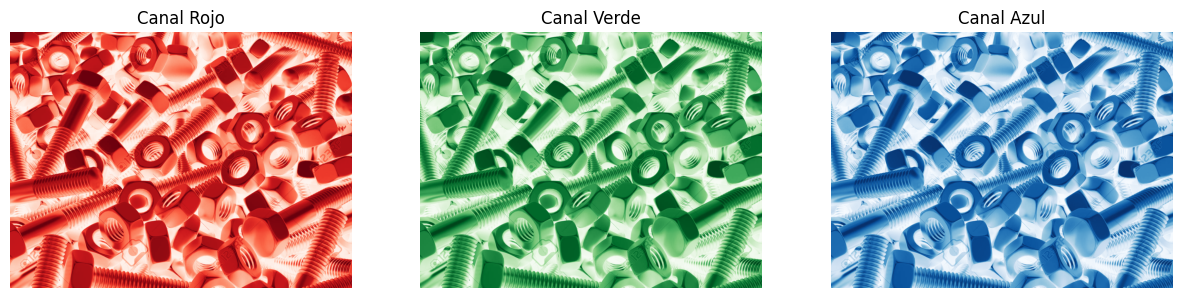

In [15]:
#Librerias cv2 para binarizacion de imagenes
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure, segmentation, filters, exposure
from scipy import ndimage
from skimage.feature import peak_local_max
import pandas as pd
import os

# Crear directorio para resultados
os.makedirs('resultados', exist_ok=True)

# A. Carga inicial de imagen -- > hacemos la transformacion a RGB
img = cv2.imread('./imagenes/img1.jpg')

if img is None:
	raise FileNotFoundError("No se pudo cargar la imagen './imagenes/img2.jpg'. Verifique la ruta y el archivo.")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar imagen original
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.title('Imagen Original de Tornillos')
plt.axis('off')
plt.savefig('resultados/01_imagen_original.jpg')
plt.show()

# Obtener información de la imagen
height, width, channels = img.shape
print(f"Tamaño de la imagen: {width}x{height} píxeles")
print(f"Canales: {channels} (RGB)")
print(f"Tipo de datos: {img.dtype}")

# Separar canales RGB
r_channel = img_rgb[:, :, 0]
g_channel = img_rgb[:, :, 1]
b_channel = img_rgb[:, :, 2]

# Mostrar canales por separado
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(r_channel, cmap='Reds')
axes[0].set_title('Canal Rojo')
axes[0].axis('off')

axes[1].imshow(g_channel, cmap='Greens')
axes[1].set_title('Canal Verde')
axes[1].axis('off')

axes[2].imshow(b_channel, cmap='Blues')
axes[2].set_title('Canal Azul')
axes[2].axis('off')
plt.savefig('resultados/02_canales_rgb.jpg')
plt.show()

# Librerías Utilizadas y Fundamentos Teóricos

En este notebook se utilizan diversas librerías de Python, cada una con un propósito específico en el procesamiento de imágenes:

- **OpenCV (cv2):** Proporciona herramientas para la manipulación de imágenes, como la lectura, conversión de formatos y operaciones morfológicas. Basado en álgebra lineal y transformaciones geométricas.
- **NumPy:** Permite manejar matrices y realizar operaciones matemáticas eficientes, fundamentales para representar imágenes como arreglos numéricos.
- **Matplotlib:** Utilizado para la visualización de imágenes y resultados intermedios.
- **Scikit-Image:** Ofrece funciones avanzadas para segmentación, análisis de regiones y detección de bordes, basadas en técnicas de procesamiento digital de señales.
- **SciPy:** Complementa con herramientas para operaciones matemáticas avanzadas, como transformadas de distancia.
- **Pandas:** Facilita la creación y manipulación de datasets para almacenar las propiedades de los tornillos detectados.

Estas librerías permiten implementar un flujo de trabajo robusto para el análisis y conteo de tornillos en imágenes.

# Conversión a Escala de Grises y Binarización #

#### Umbral fijo (120): Valor determinado empíricamente que funciona bien para imágenes con iluminación uniforme

#### Umbral adaptativo: Calcula umbrales locales para cada región de la imagen (tamaño de bloque 11, constante 2)

#### El parámetro THRESH_BINARY_INV se usa porque los tornillos suelen ser más oscuros que el fondo

#### El tamaño de bloque (11) debe ser impar y mayor que el tamaño esperado de los objetos a detectar ####

# Conversión a Escala de Grises y Binarización: Fundamentos

La conversión a escala de grises y la binarización son pasos esenciales en el procesamiento de imágenes para simplificar la información visual:

- **Escala de Grises:** Reduce la dimensionalidad de la imagen al eliminar la información de color, manteniendo la intensidad luminosa. Esto se logra mediante una combinación ponderada de los canales RGB.
  - Fórmula: `Gray = 0.2989*R + 0.5870*G + 0.1140*B`

- **Binarización:** Convierte la imagen en blanco y negro (valores 0 y 255) para resaltar los objetos de interés. Se utilizan dos métodos:
  - **Umbral Fijo:** Se aplica un valor constante para separar los píxeles claros y oscuros. Ideal para imágenes con iluminación uniforme.
  - **Umbral Adaptativo:** Calcula umbrales locales considerando regiones pequeñas de la imagen, útil para condiciones de iluminación variables.

Estos pasos preparan la imagen para análisis posteriores, destacando los tornillos y eliminando información irrelevante.

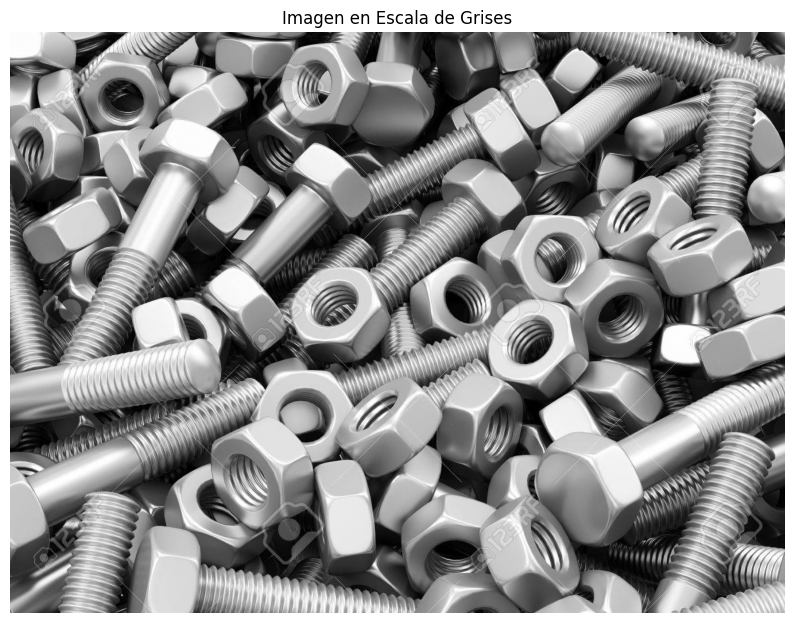

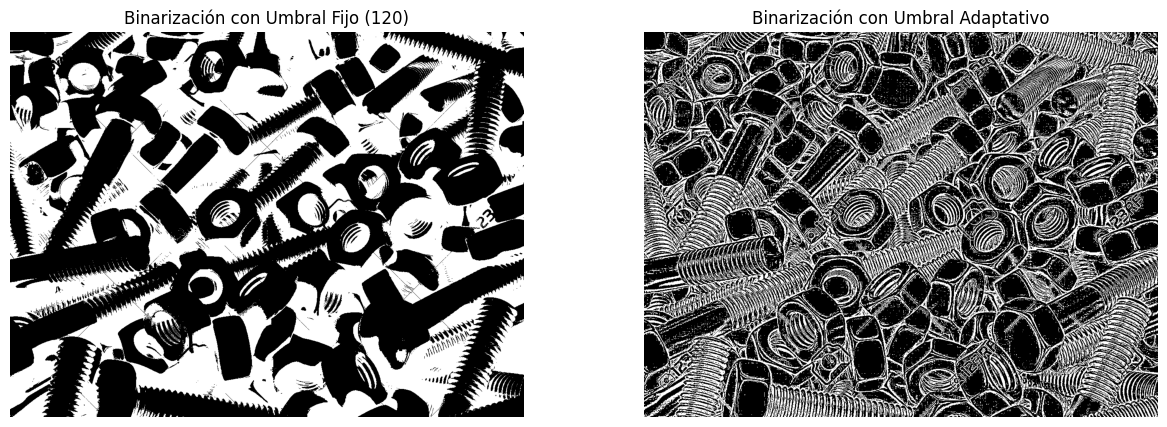

In [16]:
# Conversión a escala de grises
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Mostrar imagen en escala de grises
plt.figure(figsize=(10, 8))
plt.imshow(gray, cmap='gray')
plt.title('Imagen en Escala de Grises')
plt.axis('off')
plt.savefig('resultados/03_escala_grises.jpg')
plt.show()

# Binarización con umbral fijo (para comparación)
_, binary_fixed = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

# Binarización con umbral adaptativo (mejor para condiciones variables)
binary_adaptive = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, 11, 2
)

# Mostrar resultados de binarización
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(binary_fixed, cmap='gray')
axes[0].set_title('Binarización con Umbral Fijo (120)')
axes[0].axis('off')

axes[1].imshow(binary_adaptive, cmap='gray')
axes[1].set_title('Binarización con Umbral Adaptativo')
axes[1].axis('off')
plt.savefig('resultados/04_binarizacion.jpg')
plt.show()

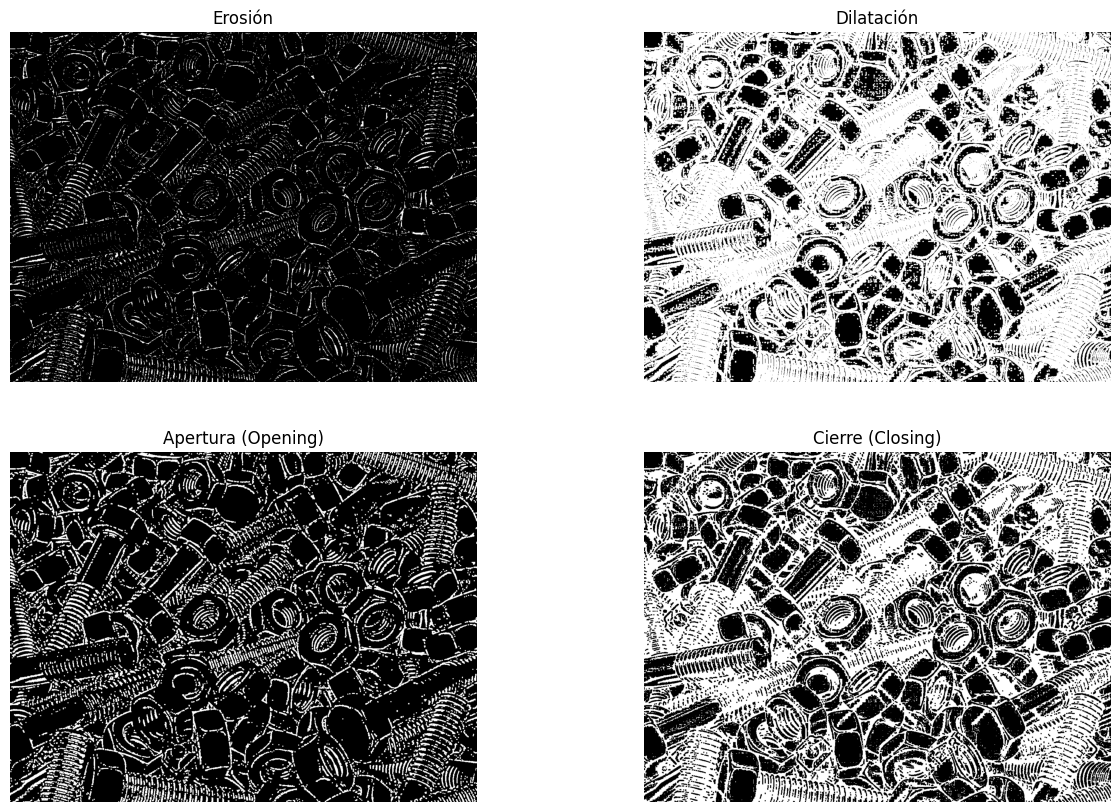

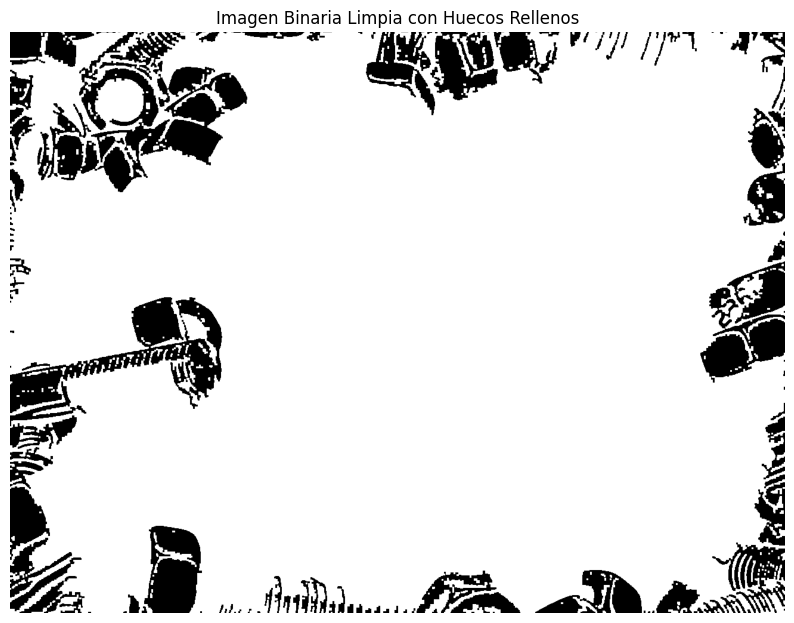

In [17]:
# Definir kernel para operaciones morfológicas
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Aplicar operaciones morfológicas
eroded = cv2.erode(binary_adaptive, kernel, iterations=1)
dilated = cv2.dilate(binary_adaptive, kernel, iterations=1)
opened = cv2.morphologyEx(binary_adaptive, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(binary_adaptive, cv2.MORPH_CLOSE, kernel)

# Mostrar operaciones morfológicas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].imshow(eroded, cmap='gray')
axes[0, 0].set_title('Erosión')
axes[0, 0].axis('off')

axes[0, 1].imshow(dilated, cmap='gray')
axes[0, 1].set_title('Dilatación')
axes[0, 1].axis('off')

axes[1, 0].imshow(opened, cmap='gray')
axes[1, 0].set_title('Apertura (Opening)')
axes[1, 0].axis('off')

axes[1, 1].imshow(closed, cmap='gray')
axes[1, 1].set_title('Cierre (Closing)')
axes[1, 1].axis('off')
plt.savefig('resultados/05_operaciones_morfologicas.jpg')
plt.show()

# Mejorar la imagen binaria con operaciones combinadas
cleaned = cv2.morphologyEx(binary_adaptive, cv2.MORPH_CLOSE, kernel)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

# Rellenar huecos internos
filled = ndimage.binary_fill_holes(cleaned)

plt.figure(figsize=(10, 8))
plt.imshow(filled, cmap='gray')
plt.title('Imagen Binaria Limpia con Huecos Rellenos')
plt.axis('off')
plt.savefig('resultados/06_binaria_limpia.jpg')
plt.show()

# Operaciones Morfológicas: Teoría y Propósito

Las operaciones morfológicas son técnicas basadas en la teoría de conjuntos y geometría matemática, utilizadas para mejorar la calidad de las imágenes binarias:

- **Erosión:** Reduce las regiones blancas (objetos) eliminando píxeles en los bordes. Útil para separar objetos conectados.
- **Dilatación:** Expande las regiones blancas, rellenando huecos pequeños y conectando objetos cercanos.
- **Apertura (Opening):** Erosión seguida de dilatación. Elimina ruido pequeño mientras preserva la forma de los objetos.
- **Cierre (Closing):** Dilatación seguida de erosión. Rellena huecos pequeños dentro de los objetos.

Estas operaciones son esenciales para limpiar la imagen binaria, eliminando ruido y mejorando la segmentación de los tornillos.

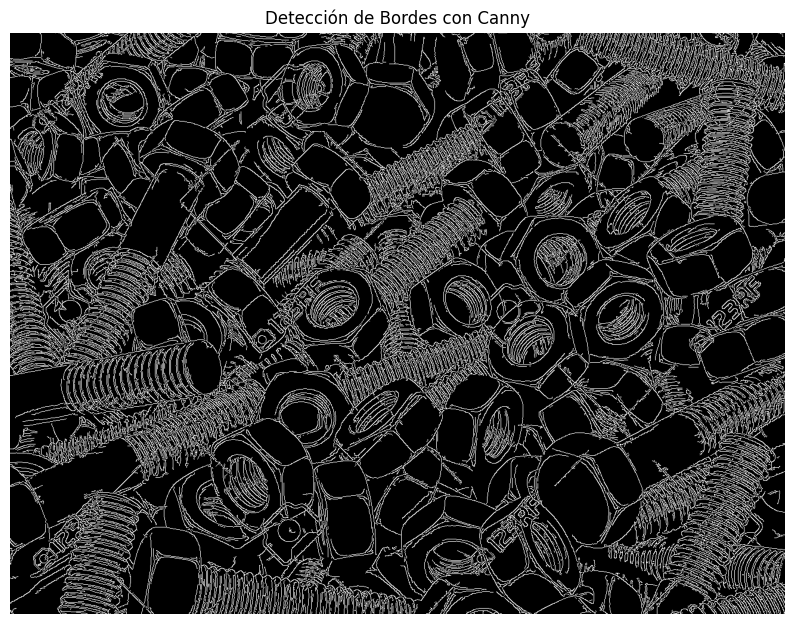

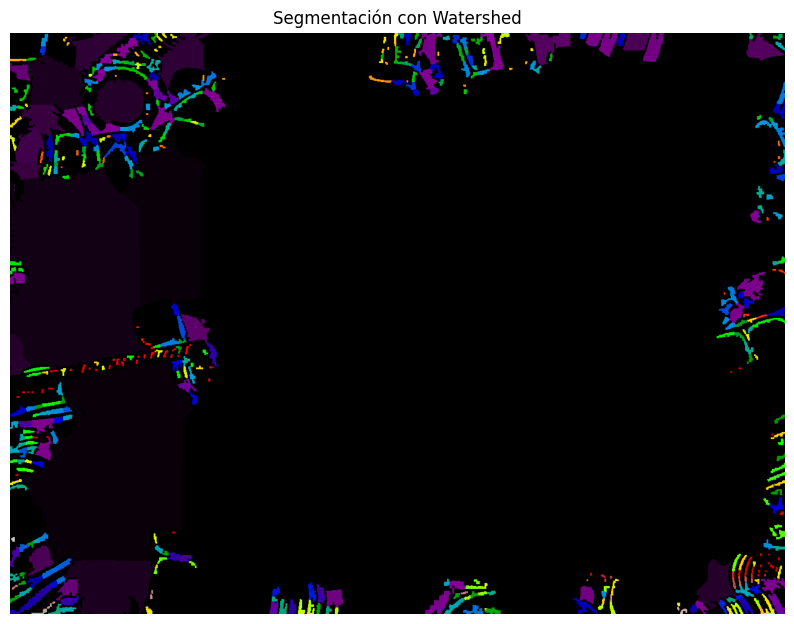

In [18]:
# Detección de bordes con Canny
edges = cv2.Canny(gray, 50, 150)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.title('Detección de Bordes con Canny')
plt.axis('off')
plt.savefig('resultados/07_bordes_canny.jpg')
plt.show()

# Transformada de distancia para Watershed
distance = ndimage.distance_transform_edt(filled)
local_max = peak_local_max(distance, min_distance=7, labels=filled)

# Crear marcadores para Watershed
markers = np.zeros_like(filled, dtype=np.int32)
for i, (y, x) in enumerate(local_max):
    markers[y, x] = i + 1

# Aplicar Watershed
ws_labels = segmentation.watershed(-distance, markers, mask=filled)

plt.figure(figsize=(10, 8))
plt.imshow(ws_labels, cmap='nipy_spectral')
plt.title('Segmentación con Watershed')
plt.axis('off')
plt.savefig('resultados/08_watershed.jpg')
plt.show()

# Detección de Bordes y Segmentación con Watershed

La detección de bordes y la segmentación son pasos cruciales para identificar y separar los tornillos en la imagen:

- **Detección de Bordes (Canny):** Identifica los contornos de los objetos mediante gradientes de intensidad. Utiliza un algoritmo basado en derivadas y umbrales para resaltar los bordes más significativos.

- **Transformada de Distancia:** Calcula la distancia de cada píxel al borde más cercano, creando un mapa de distancia que resalta los centros de los objetos.

- **Segmentación Watershed:** Divide la imagen en regiones basándose en el mapa de distancia. Los marcadores iniciales se expanden hasta llenar las regiones, separando los objetos superpuestos.

Estas técnicas permiten identificar y segmentar los tornillos, incluso en casos donde están parcialmente conectados o superpuestos.

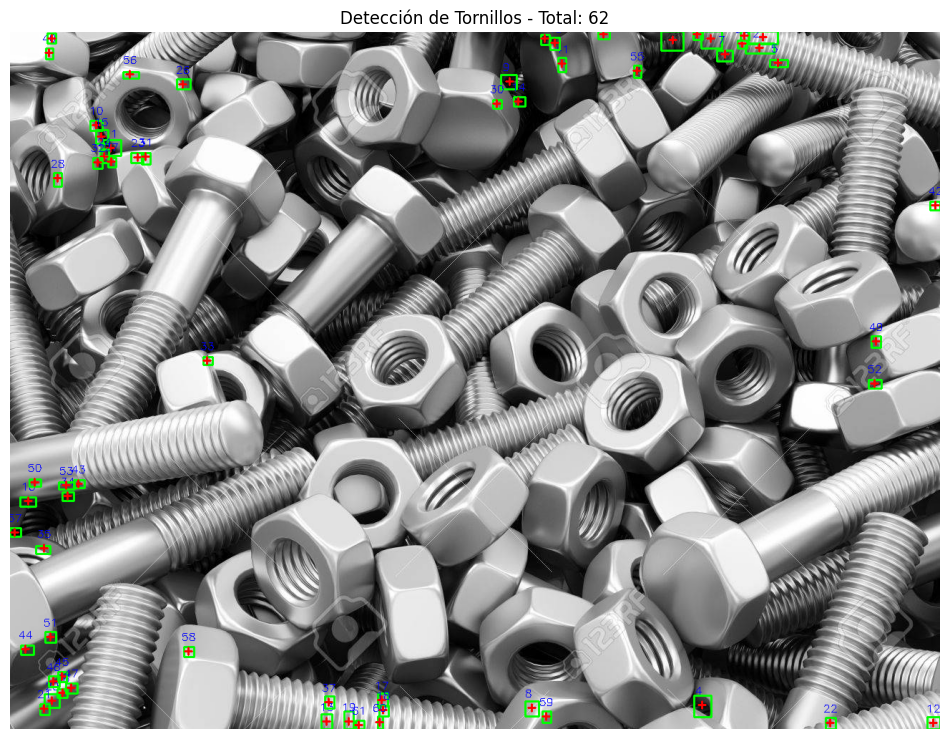

In [19]:
# Analizar regiones
regions = measure.regionprops(ws_labels)

# Filtrar regiones por área y circularidad
min_area = 100  # Área mínima esperada para un tornillo
max_area = 5000  # Área máxima esperada para un tornillo

valid_regions = []
for region in regions:
    if min_area <= region.area <= max_area:
        # Calcular circularidad
        perimeter = region.perimeter
        if perimeter > 0:
            circularity = 4 * np.pi * region.area / (perimeter ** 2)
            # Los tornillos suelen ser circulares (circularidad > 0.6)
            if circularity > 0.6:
                valid_regions.append(region)

# Crear imagen con bounding boxes y centroides
result_image = img_rgb.copy()
for i, region in enumerate(valid_regions):
    # Dibujar bounding box
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(result_image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    
    # Dibujar centroide
    y, x = region.centroid
    cv2.drawMarker(result_image, (int(x), int(y)), (255, 0, 0), markerType=cv2.MARKER_CROSS, 
                  markerSize=10, thickness=2)
    
    # Añadir número de identificación
    cv2.putText(result_image, str(i+1), (int(x)-10, int(y)-15), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

plt.figure(figsize=(12, 10))
plt.imshow(result_image)
plt.title(f'Detección de Tornillos - Total: {len(valid_regions)}')
plt.axis('off')
plt.savefig('resultados/09_deteccion_final.jpg')
plt.show()

# Análisis de Regiones y Filtrado de Tornillos

El análisis de regiones permite extraer propiedades geométricas y estadísticas de los objetos detectados:

- **Propiedades de Regiones:** Se calculan características como área, perímetro, centroides y bounding boxes.
- **Filtrado por Área:** Se descartan regiones demasiado pequeñas o grandes para ser tornillos.
- **Circularidad:** Se utiliza la fórmula `4π(area/perimeter²)` para medir qué tan circular es un objeto. Los tornillos suelen tener una circularidad mayor a 0.6.

Este análisis asegura que solo se consideren los tornillos válidos, eliminando falsos positivos como ruido o artefactos en la imagen.

In [20]:
# Crear dataset con propiedades de los tornillos
tornillos_data = []

for i, region in enumerate(valid_regions):
    # Calcular propiedades adicionales
    eccentricity = region.eccentricity
    orientation = region.orientation
    solidity = region.solidity
    
    # Calcular relación de aspecto del bounding box
    minr, minc, maxr, maxc = region.bbox
    aspect_ratio = (maxc - minc) / (maxr - minr) if (maxr - minr) > 0 else 0
    
    tornillos_data.append({
        'id': i+1,
        'area': region.area,
        'perimetro': region.perimeter,
        'centroide_x': region.centroid[1],
        'centroide_y': region.centroid[0],
        'diametro_equivalente': region.equivalent_diameter,
        'excentricidad': eccentricity,
        'orientacion': orientation,
        'solidez': solidity,
        'relacion_aspecto': aspect_ratio,
        'bbox_x1': minc,
        'bbox_y1': minr,
        'bbox_x2': maxc,
        'bbox_y2': maxr
    })

# Convertir a DataFrame
df_tornillos = pd.DataFrame(tornillos_data)

# Guardar en CSV
df_tornillos.to_csv('resultados/dataset_tornillos.csv', index=False)

# Mostrar resumen estadístico
print(f"Total de tornillos detectados: {len(valid_regions)}")
print("\nResumen estadístico:")
print(df_tornillos.describe())

# Mostrar primeras filas del dataset
print("\nPrimeras filas del dataset:")
print(df_tornillos.head())

Total de tornillos detectados: 62

Resumen estadístico:
              id        area   perimetro  centroide_x  centroide_y  \
count  62.000000   62.000000   62.000000    62.000000    62.000000   
mean   31.500000  183.741935   55.189475   488.344995   453.343427   
std    18.041619  123.624887   16.374489   420.687694   396.824843   
min     1.000000  100.000000   38.727922     6.198473     4.588235   
25%    16.250000  116.750000   44.579951    81.700155    57.023174   
50%    31.500000  138.000000   50.142136   444.095860   338.120746   
75%    46.750000  194.750000   57.920310   865.097935   915.319581   
max    62.000000  635.000000  108.384776  1293.232000   969.638095   

       diametro_equivalente  excentricidad  orientacion    solidez  \
count             62.000000      62.000000    62.000000  62.000000   
mean              14.738382       0.764375    -0.109656   0.883273   
std                4.123325       0.124666     0.956779   0.032334   
min               11.283792      

# Creación del Dataset y Resumen de Resultados

El dataset final contiene las propiedades calculadas para cada tornillo detectado, lo que permite un análisis detallado:

- **Propiedades Incluidas:** Área, perímetro, centroides, diámetro equivalente, excentricidad, orientación, solidez, relación de aspecto y coordenadas del bounding box.
- **Uso de Pandas:** Se utiliza para estructurar los datos en un formato tabular y exportarlos a un archivo CSV.
- **Resumen Estadístico:** Proporciona métricas clave como promedio, desviación estándar y distribución de áreas.

Este dataset es esencial para validar los resultados y realizar análisis adicionales, como la evaluación de la calidad de los tornillos detectados.

REPORTE FINAL DE CONTEO DE TORNILLOS
Imagen analizada: 1300x975 píxeles
Tornillos detectados: 62
Tasa de detección: 0.49 tornillos por 10,000 píxeles

Distribución de áreas:
  Mínima: 100.00 píxeles
  Máxima: 635.00 píxeles
  Promedio: 183.74 píxeles
  Desviación estándar: 123.62 píxeles


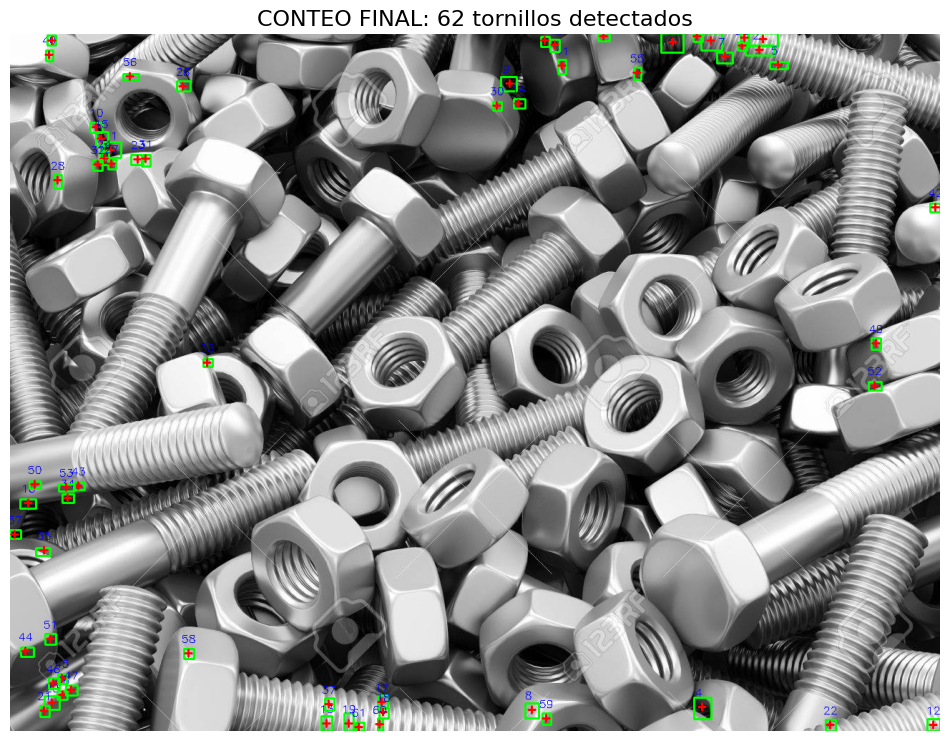

In [21]:
# Generar reporte final
print("="*50)
print("REPORTE FINAL DE CONTEO DE TORNILLOS")
print("="*50)
print(f"Imagen analizada: {width}x{height} píxeles")
print(f"Tornillos detectados: {len(valid_regions)}")
print(f"Tasa de detección: {len(valid_regions)/(width*height/10000):.2f} tornillos por 10,000 píxeles")
print("\nDistribución de áreas:")
print(f"  Mínima: {df_tornillos['area'].min():.2f} píxeles")
print(f"  Máxima: {df_tornillos['area'].max():.2f} píxeles")
print(f"  Promedio: {df_tornillos['area'].mean():.2f} píxeles")
print(f"  Desviación estándar: {df_tornillos['area'].std():.2f} píxeles")

# Guardar imagen final con conteo
plt.figure(figsize=(12, 10))
plt.imshow(result_image)
plt.title(f'CONTEO FINAL: {len(valid_regions)} tornillos detectados', fontsize=16)
plt.axis('off')
plt.savefig('resultados/10_resultado_final.jpg', dpi=300, bbox_inches='tight')
plt.show()